<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/alpha/af/examples/AF2Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF2Rank
[AF2Rank](https://github.com/jproney/AF2Rank) implemented using ColabDesign. 

If you find useful, please cite:
- Roney, J.P. and Ovchinnikov, S., 2022. **State-of-the-Art estimation of protein model accuracy using AlphaFold**. [BioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.11.484043v3.full).

In [1]:
#@title ## Setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git
  # for debugging
  ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  # download openfold weights (optional)
  for W in openfold_model_ptm_1 openfold_model_ptm_2
  do wget -qnc https://files.ipd.uw.edu/krypton/openfold/${W}.npz -P params; done

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

In [2]:
#@title import libraries
from colabdesign import clear_mem, mk_af_model
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

def get_score(model, wt_batch=None):
  score = model.aux["log"]

  score["plddt"] = 1 - score["plddt"]
  score["pae"] = score["pae"] * 31.0
  score["rmsd_io"] = score.pop("rmsd",None)

  i_xyz = model._inputs["batch"]["all_atom_positions"][:,1]
  o_xyz = np.array(model.aux["atom_positions"][:,1])

  # TMscore to input/output
  if wt_batch is not None:
    n_xyz = wt_batch["all_atom_positions"][:,1]
    score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
    score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

  # TMscore between input and output
  score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

  # composite score
  score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
  return score

## rank structures

In [14]:
NAME = "1agy"
CHAINS = "A"
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"

# get data
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives/{NAME}.pdb
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/decoys/{NAME}.zip
%shell unzip -qqo {NAME}.zip

# setup model
clear_mem()
model = mk_af_model(protocol="fixbb", use_templates=True,
                    use_alphafold=True, use_openfold=True)
model.prep_inputs(NATIVE_PATH, chains=CHAINS)

# save wildtype inputs
WT_BATCH = model._inputs["batch"]
WT_SEQ = np.eye(20)[WT_BATCH["aatype"]]

In [15]:
#@markdown ### Settings
seq_relacement = "gap" #@param ["gap", "X", "A", "none"]
mask_sidechains = True #@param {type:"boolean"}
recycles = 1 #@param ["0", "1", "2", "3"] {type:"raw"}
model_name = "model_1_ptm" #@param ["model_1_ptm", "model_2_ptm", "openfold_model_ptm_1", "openfold_model_ptm_2"]

RM_TM_SEQ = seq_relacement != "none"
RM_TM_SC = not mask_sidechains
RECYCLES = int(recycles)
MODEL_NAME = model_name

TM_AATYPE = -1
if seq_relacement == "A": TM_AATYPE = 0
if seq_relacement == "gap": TM_AATYPE = 21
if seq_relacement == "X":   TM_AATYPE = 20

def predict(pdb_path, chains="A", input_template=True, verbose=True):
  model.prep_inputs(pdb_path, chains=chains)
  model.set_opt(template=dict(dropout=not input_template),
                rm_template_seq=RM_TM_SEQ, rm_template_sc=RM_TM_SC,
                num_recycles=RECYCLES)
  model.set_seq(seq=WT_SEQ)
  model.predict(models=[MODEL_NAME], verbose=False)
  score = get_score(model, WT_BATCH)
  score["id"] = pdb_path
  if verbose:
    print(*[f"{k} {score[k]:.4f}" for k in ["tm_i","tm_o","tm_io","composite","ptm","plddt"]], score["id"])
  return score

In [16]:
# score no structure
_ = predict(NATIVE_PATH, CHAINS, input_template=False)

tm_i 1.0000 tm_o 0.2987 tm_io 0.2987 composite 0.0356 ptm 0.3401 plddt 0.3501 1agy.pdb


In [ ]:
SCORES = []

# score with structure
SCORES.append(predict(NATIVE_PATH, input_template=True))

# score the decoy sctructures
for decoy_pdb in os.listdir(DECOY_DIR):
  decoy_path = os.path.join(DECOY_DIR, decoy_pdb)
  SCORES.append(predict(decoy_path, CHAINS))

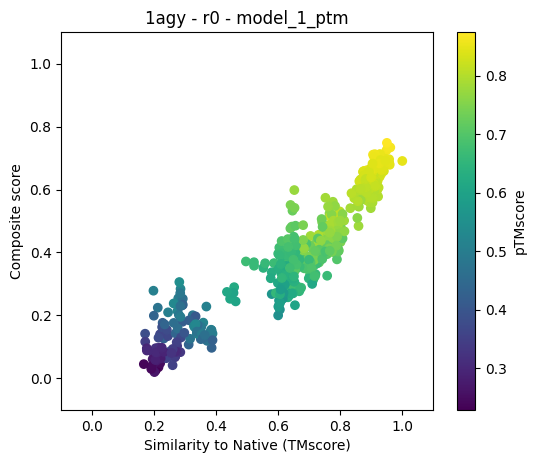

0.9495654933467994


In [20]:
plt.figure(figsize=(6,5),dpi=100)
plt.title(f"{NAME} - r{RECYCLES} - {MODEL_NAME}")
x = np.array([k["tm_i"] for k in SCORES])
y = np.array([k["composite"] for k in SCORES])
c = np.array([k["ptm"] for k in SCORES])
plt.scatter(x,y,c=c)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("Composite score")
plt.colorbar(label="pTMscore")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

# rank correlation to composite score
print(spearmanr(x,y).correlation)

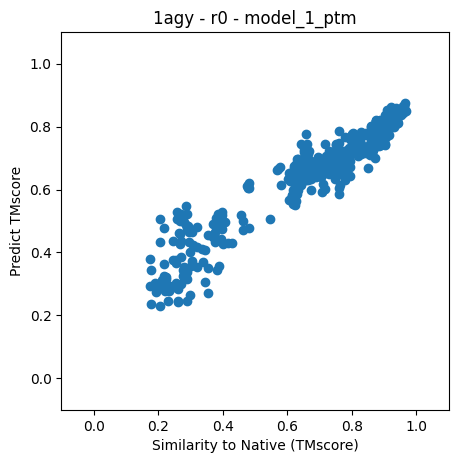

0.9577279050332527


In [24]:
plt.figure(figsize=(5,5),dpi=100)
plt.title(f"{NAME} - r{RECYCLES} - {MODEL_NAME}")
x = np.array([k["tm_o"] for k in SCORES])
y = np.array([k["ptm"] for k in SCORES])
plt.scatter(x,y)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("Predict TMscore")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

# rank correlation to pTMscore
print(spearmanr(x,y).correlation)

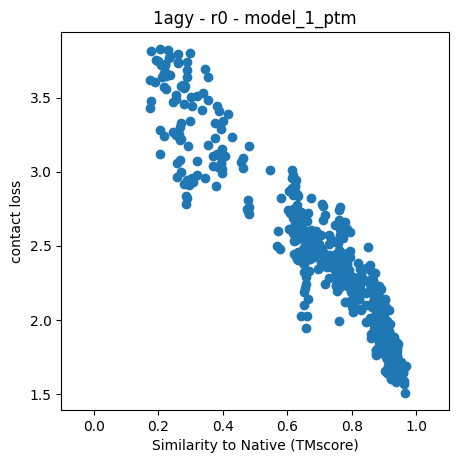

-0.9505233786378541


In [22]:
plt.figure(figsize=(5,5),dpi=100)
plt.title(f"{NAME} - r{RECYCLES} - {MODEL_NAME}")
x = np.array([k["tm_o"] for k in SCORES])
y = np.array([k["con"] for k in SCORES])
plt.scatter(x,y)
plt.xlabel("Similarity to Native (TMscore)")
plt.ylabel("contact loss")
plt.xlim(-0.1,1.1)
plt.show()

# rank correlation to pTMscore
print(spearmanr(x,y).correlation)